# Modeling after Data Segmentation

### Loading

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
sys.path.append(r'C:\Frank\UoT 2024-2025\MIE8888 Project\M18\RUIWU') 
from helper_functions import * # Import Ruiwu's helper functions for data cleaning, slicing and aggregating

full_dataset = r"C:\Frank\UoT 2024-2025\MIE8888 Project\full_dataset_2.11.csv"
v1_data = r"C:\Frank\UoT 2024-2025\MIE8888 Project\M19\df_v1.csv"
v2_data = r"C:\Frank\UoT 2024-2025\MIE8888 Project\M19\df_v2.csv"
df = pd.read_csv(full_dataset, encoding="Windows-1252")
df_v1 = pd.read_csv(v1_data, encoding="Windows-1252")
df_v2 = pd.read_csv(v2_data, encoding="Windows-1252")

C:\Users\frank\AppData\Local\Temp\ipykernel_32452\1302865025.py:11: DtypeWarning: Columns (1,4,10,16,52,85,86,91) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(full_dataset, encoding="Windows-1252")


### Using V2 data for models (V2 (Inconsistent but Long History): Max gap is 2 years or more; Total duration is 7 years or more)

In [7]:
df_v2.columns

Index(['provider_x', 'amount', 'treatment_plan_status', 'procedure_date',
       'patient_id', 'birth_date', 'city', 'state_y', 'first_visit',
       'last_visit',
       ...
       'treatment_category_13', 'treatment_category_14',
       'treatment_category_15', 'treatment_category_16',
       'treatment_category_17', 'treatment_category_18',
       'treatment_category_19', 'treatment_category_20',
       'treatment_category_21', 'version'],
      dtype='object', length=620)

#### Idea1: (Not sequentially)
Multi-Hot Input + MLP (Feedforward Neural Network)

Test model: Build a multi-hot vector per patient over ages 31–35 -> Predict procedures in age 36

Input shape: [batch_size, num_ages × num_procedures]
Output: [batch_size, num_procedures] (sigmoid for multi-label)

In [9]:
import pandas as pd
import os
from functools import reduce

folder = r"C:\Frank\UoT 2024-2025\MIE8888 Project\M19\Split dataframe yearly"
age_inputs = ['31', '32', '33', '34', '35']
age_target = '36'

# Load and combine input years
input_dfs = []
for age in age_inputs:
    path = os.path.join(folder, f"age_group_{age}.csv")
    if os.path.exists(path):
        df = pd.read_csv(path)
        proc_cols = [col for col in df.columns if col.startswith('procedure_code_y_')]
        df_grouped = df.groupby('patient_id')[proc_cols].sum().reset_index()
        df_grouped = df_grouped.set_index('patient_id')
        input_dfs.append(df_grouped)

# Merge inputs and binarize
X = reduce(lambda left, right: left.add(right, fill_value=0), input_dfs)
X = (X > 0).astype(int)

# Load target year (age 36)
target_path = os.path.join(folder, f"age_group_{age_target}.csv")
df_target = pd.read_csv(target_path)
proc_cols = [col for col in df_target.columns if col.startswith('procedure_code_y_')]
df_y = df_target.groupby('patient_id')[proc_cols].sum().reset_index().set_index('patient_id')
y = (df_y > 0).astype(int)

# Align X and y
X, y = X.align(y, join='inner', axis=0)

print(f"Input shape: {X.shape}")
print(f"Target shape: {y.shape}")

Input shape: (1056, 582)
Target shape: (1056, 582)


Get all procedure code columns; Group by patient, summing across multiple rows if they had multiple visits in that year.  
After that, merge all input years into a single input matrix
- Each row = 1 patient
- Each column = 1 procedure
- Value = 1 if that patient had that procedure in any of ages 31–35  

Ensures both input and target contain only the same patients. If a patient is missing from either side, they are excluded. Resulting X and y are now ready for model training


### MLP

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ProcedureMLP(nn.Module):
    """
    Args:
    input_dim: Number of input features (procedures from previous years)
    output_dim: Number of target procedure labels (next year)
    hidden_dims: List of hidden layer sizes
    dropout: Dropout rate between layers
    """
    def __init__(self, input_dim, output_dim, hidden_dims=[256, 128], dropout=0.3):
        super(ProcedureMLP, self).__init__()
        layers = []
        dims = [input_dim] + hidden_dims

        for i in range(len(dims) - 1):
            layers.append(nn.Linear(dims[i], dims[i + 1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))  # optional dropout

        # Final output layer (no dropout or activation here)
        layers.append(nn.Linear(dims[-1], output_dim))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        # Sigmoid activation for multi-label output
        return torch.sigmoid(self.network(x))


In [21]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt

X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32)

# Data spliting
df_v2 = TensorDataset(X_tensor, y_tensor)
n = len(df_v2)
train_len = int(n * 0.7)
val_len = int(n * 0.15)
test_len = n - train_len - val_len
train_set, val_set, test_set = random_split(df_v2, [train_len, val_len, test_len])

Epoch 1 | Train Loss: 0.2447 | Val Loss: 0.0899 | Train Acc: 0.9121 | Val Acc: 0.9852
Epoch 2 | Train Loss: 0.0806 | Val Loss: 0.0942 | Train Acc: 0.9885 | Val Acc: 0.9899
Epoch 3 | Train Loss: 0.0782 | Val Loss: 0.0848 | Train Acc: 0.9904 | Val Acc: 0.9935
Epoch 4 | Train Loss: 0.0652 | Val Loss: 0.0580 | Train Acc: 0.9917 | Val Acc: 0.9926
Epoch 5 | Train Loss: 0.0488 | Val Loss: 0.0466 | Train Acc: 0.9920 | Val Acc: 0.9931
Epoch 6 | Train Loss: 0.0361 | Val Loss: 0.0337 | Train Acc: 0.9930 | Val Acc: 0.9935
Epoch 7 | Train Loss: 0.0279 | Val Loss: 0.0276 | Train Acc: 0.9935 | Val Acc: 0.9935
Epoch 8 | Train Loss: 0.0246 | Val Loss: 0.0254 | Train Acc: 0.9937 | Val Acc: 0.9935
Epoch 9 | Train Loss: 0.0223 | Val Loss: 0.0244 | Train Acc: 0.9937 | Val Acc: 0.9935
Epoch 10 | Train Loss: 0.0212 | Val Loss: 0.0235 | Train Acc: 0.9937 | Val Acc: 0.9935


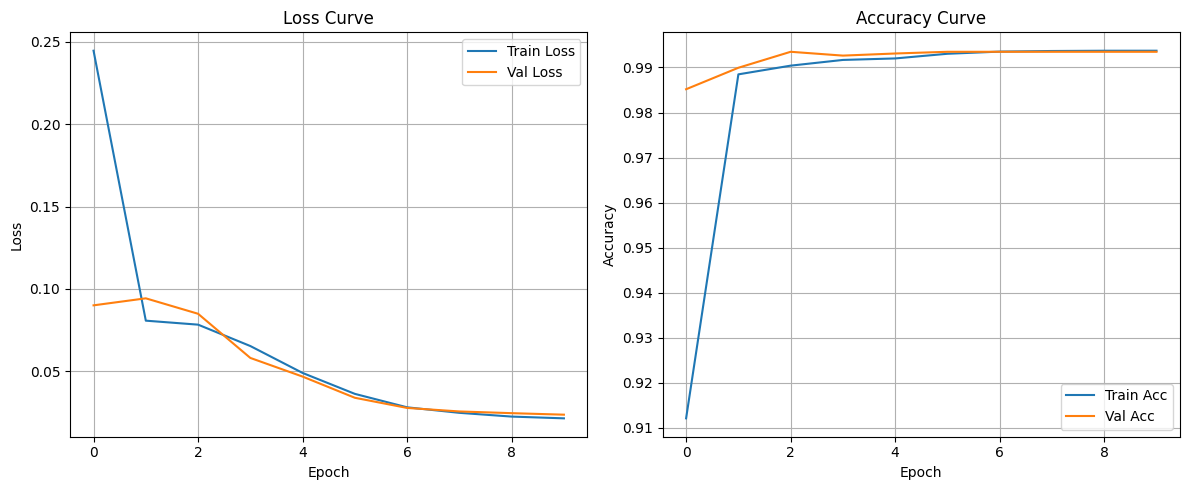

In [22]:
# Training setup
batch_size = 128
learning_rate = 0.01
num_epochs = 10
model = ProcedureMLP(input_dim=X_tensor.shape[1], output_dim=y_tensor.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), learning_rate)

# Training loop
train_loader = DataLoader(train_set, batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size)
test_loader = DataLoader(test_set, batch_size)
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    # Train
    model.train()
    total_loss, correct, total = 0, 0, 0
    for xb, yb in train_loader:
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (pred >= 0.5).eq(yb).sum().item()
        total += torch.numel(yb)
    train_losses.append(total_loss / len(train_loader))
    train_accs.append(correct / total)

    # Validate
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            pred = model(xb)
            val_loss += criterion(pred, yb).item()
            val_correct += (pred >= 0.5).eq(yb).sum().item()
            val_total += torch.numel(yb)
    val_losses.append(val_loss / len(val_loader))
    val_accs.append(val_correct / val_total)

    print(f"Epoch {epoch+1} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f} | "
          f"Train Acc: {train_accs[-1]:.4f} | Val Acc: {val_accs[-1]:.4f}")

# Plot curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Fine Tuning

Epoch 1 | Train Loss: 0.6905 | Val Loss: 0.6888 | Train Acc: 0.5477 | Val Acc: 0.5755
Epoch 2 | Train Loss: 0.6869 | Val Loss: 0.6847 | Train Acc: 0.5920 | Val Acc: 0.6261
Epoch 3 | Train Loss: 0.6816 | Val Loss: 0.6779 | Train Acc: 0.6504 | Val Acc: 0.7019
Epoch 4 | Train Loss: 0.6727 | Val Loss: 0.6656 | Train Acc: 0.7255 | Val Acc: 0.7988
Epoch 5 | Train Loss: 0.6567 | Val Loss: 0.6434 | Train Acc: 0.8078 | Val Acc: 0.8833
Epoch 6 | Train Loss: 0.6288 | Val Loss: 0.6061 | Train Acc: 0.8787 | Val Acc: 0.9353
Epoch 7 | Train Loss: 0.5828 | Val Loss: 0.5491 | Train Acc: 0.9307 | Val Acc: 0.9672
Epoch 8 | Train Loss: 0.5185 | Val Loss: 0.4714 | Train Acc: 0.9638 | Val Acc: 0.9860
Epoch 9 | Train Loss: 0.4355 | Val Loss: 0.3803 | Train Acc: 0.9814 | Val Acc: 0.9931
Epoch 10 | Train Loss: 0.3470 | Val Loss: 0.2892 | Train Acc: 0.9895 | Val Acc: 0.9935
Epoch 11 | Train Loss: 0.2628 | Val Loss: 0.2122 | Train Acc: 0.9925 | Val Acc: 0.9935
Epoch 12 | Train Loss: 0.1956 | Val Loss: 0.1555 | T

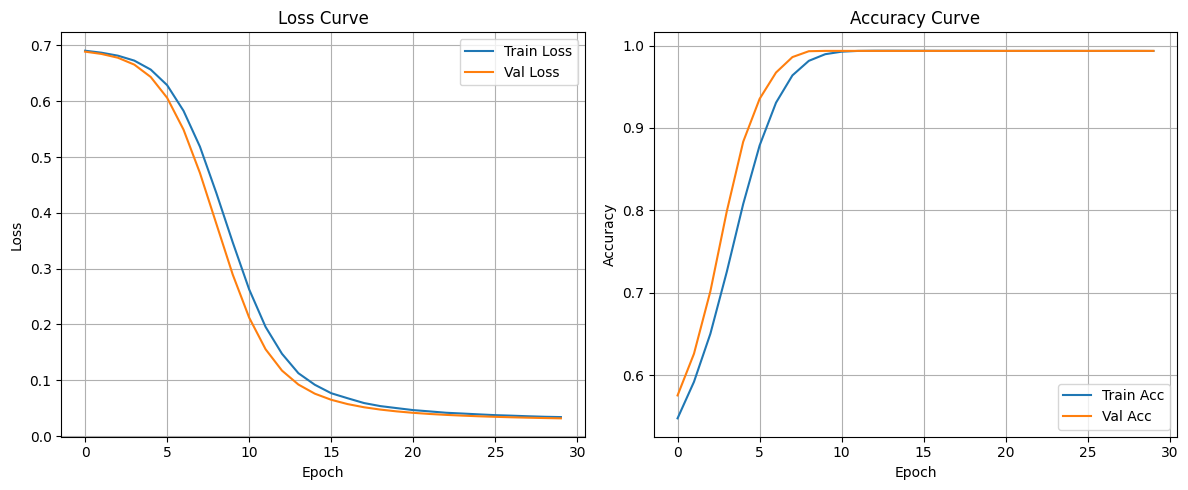

In [ ]:
# Training setup
batch_size = 64
learning_rate = 0.0001
num_epochs = 30
model = ProcedureMLP(input_dim=X_tensor.shape[1], output_dim=y_tensor.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), learning_rate)

# Training loop
train_loader = DataLoader(train_set, batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size)
test_loader = DataLoader(test_set, batch_size)
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    # Train
    model.train()
    total_loss, correct, total = 0, 0, 0
    for xb, yb in train_loader:
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (pred >= 0.5).eq(yb).sum().item()
        total += torch.numel(yb)
    train_losses.append(total_loss / len(train_loader))
    train_accs.append(correct / total)

    # Validate
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            pred = model(xb)
            val_loss += criterion(pred, yb).item()
            val_correct += (pred >= 0.5).eq(yb).sum().item()
            val_total += torch.numel(yb)
    val_losses.append(val_loss / len(val_loader))
    val_accs.append(val_correct / val_total)

    print(f"Epoch {epoch+1} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f} | "
          f"Train Acc: {train_accs[-1]:.4f} | Val Acc: {val_accs[-1]:.4f}")

# Plot curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [32]:
# Save model
torch.save({
    'model_state': model.state_dict(),
    'input_dim': X_tensor.shape[1],
    'output_dim': y_tensor.shape[1],
    'hidden_dims': [256, 128],
    'dropout': 0.3,
    'batch_size': 64,
    'learning_rate': 1e-4,
    'epoch': 30
}, "model1_full.pth")


LSTM / GRU (Sequence Model)
How: Represent each year’s procedure codes as a time step

Difficulty: ⭐⭐⭐ (Moderate)

Why: Captures temporal dependencies and treatment progression

Your Fit: If you convert yearly data to a sequence of vectors per patient, this works great

You’ll need padded sequences → Embedding → LSTM → output layer

Collaborative Filtering (Matrix Factorization)
How: Treat each patient as a user and each procedure as an item

Difficulty: ⭐⭐ (Moderate)

Your Fit: Good if you want global embedding patterns, not necessarily age-dependent

Can use lightfm or implicit for ALS/BPR optimization